# Cluster, Label, PCA, then visualize
22JAN2020<br>
Richard Kuzma and Iain Cruickshank


### Imports

In [1]:
import pandas as pd, numpy as np, pickle, time, re

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
from sklearn.metrics import classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# ! pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY, FRAME, ALL
from pprint import pprint

from scipy.spatial.distance import cosine, euclidean
from tqdm import tqdm



In [2]:
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/CLASSIFIED/'
with open(load_path + 'metadata_plus_classification_6063.pkl', 'rb') as f:
    metadata_df = pickle.load(f)

### old metadata_df (without classification)
# load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
# with open(load_path + 'metadata_plus_classification.pkl', 'rb') as f:
#     metadata_df = pickle.load(f)

#     pd.set_option('display.max_columns', None)
# metadata_df.head(3)


Index 0 and Index 1 are the same article, but weren't collapsed into one URL (likely because article was updated with new URL. Will add the retweets/favorites and make one entry

In [3]:
print(f'DF shape before: {metadata_df.shape}')
metadata_df['url_total_retweets'][1] += metadata_df['url_total_retweets'][0]
metadata_df['url_total_favorites'][1] += metadata_df['url_total_favorites'][0]

metadata_df.drop(0, inplace=True)
metadata_df.reset_index(drop=True, inplace=True)

print(f'DF shape after: {metadata_df.shape}')
metadata_df.head()

DF shape before: (6063, 10)
DF shape after: (6062, 10)


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id_str,article_text_preprocessed,domain,url_total_retweets,url_total_favorites,group,bias,month,week_num,classified
0,1233899679924006912,yaron steinbuch february amid fears looming sc...,nypost.com,1724,1166,0,5,2020-02,9,0
1,1233899753815134208,moderna therapeutics biotech company based cam...,time.com,73061,2115,2,3,2020-02,9,0
2,1233900236768186368,discover david stanway josh smith min read sha...,www.reuters.com,0,0,2,2,2020-02,9,0
3,1233903932503711744,supported need stop drives mass epidemics rath...,www.nytimes.com,48,71,2,3,2020-02,9,0
4,1233901044175982592,continue monitor area changes surgeries schedu...,www.hopkinsmedicine.org,21,18,4,4,2020-02,9,0


In [4]:
### save the Tweet IDs
copy = metadata_df.copy(deep=True)
id_strings = pd.DataFrame(data=copy['id_str'], columns = ['id_str'])
id_strings.reset_index(inplace=True, drop=True)
print(f'shape of id_strings: {id_strings.shape}')
id_strings

shape of id_strings: (6062, 1)


,id_str
0,1233899679924006912
1,1233899753815134208
2,1233900236768186368
3,1233903932503711744
4,1233901044175982592
...,...
6057,1268200671486128128
6058,1268110965452636160
6059,1269471890839502848
6060,1267974217125048320


<br><br><br>
### Make TFIDF

In [14]:

vectorizer = TfidfVectorizer(stop_words='english', min_df=10, max_df=.8)
X = vectorizer.fit_transform(metadata_df['article_text_preprocessed'])
print('{} articles. Vocabulary: {} words'.format(X.shape[0], X.shape[1]))

### save the vectorizer
tfidf_save_name = 'tfidf_vectorizer_of_6062_classified_articles.pkl'
with open(load_path + tfidf_save_name, 'wb') as f:
    pickle.dump(vectorizer, f)



6062 articles. Vocabulary: 17763 words


In [16]:

# keep ID labels with tfidf features
tfidf_feat = pd.DataFrame(data=X.toarray())
print(f'shape of tfidf_feat: {tfidf_feat.shape}')


# id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
# id_strings.reset_index(inplace=True, drop=True)

tfidf_with_id_str = pd.concat([id_strings, tfidf_feat], axis=1, ignore_index=True)
tfidf_with_id_str.rename(columns={0: "id_str"}, inplace=True)

print(f'shape of tfidf_with_id_str: {tfidf_with_id_str.shape}')

tfidf_save_name = 'tfidf_6062_articles_df.pkl'
with open(load_path + tfidf_save_name, 'wb') as f:
    pickle.dump(tfidf_with_id_str, f)


shape of tfidf_feat: (6062, 17763)
shape of tfidf_with_id_str: (6062, 17764)


<br><br>
### make PCA

In [17]:

trans = PCA(n_components=2)
pca_feat = trans.fit_transform(tfidf_feat)
print(f'shape of pca_feat: {pca_feat.shape}')

pca_feat_df = pd.DataFrame(data=pca_feat)
print(f'shape of pca_feat_df: {pca_feat_df.shape}')
# id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
# id_strings.reset_index(inplace=True, drop=True)


pca_with_id_str = pd.concat([id_strings, pca_feat_df], axis=1, ignore_index=True)
pca_with_id_str.rename(columns={0: "id_str"}, inplace=True)
print(f'shape of pca_with_id_str: {pca_with_id_str.shape}')

save_name = 'pca_2d_6062_articles_df.pkl'

with open(load_path + save_name, 'wb') as f:
    pickle.dump(pca_with_id_str, f)


shape of pca_feat: (6062, 2)
shape of pca_feat_df: (6062, 2)
shape of pca_with_id_str: (6062, 3)


<br><br><br>
## Load PCA and TFIDF DataFrames

In [24]:
### load tfidf df
load_name = 'tfidf_6062_articles_df.pkl'
with open(load_path + load_name, 'rb') as f:
    tfidf_df = pickle.load(f)
print(f'shape of tfidf_df: {tfidf_df.shape}')



### load pca df
load_name = 'pca_2d_6062_articles_df.pkl'
with open(load_path + load_name, 'rb') as f:
    pca_df = pickle.load(f)
print(f'shape of pca_df: {pca_df.shape}')



pca_feat = pca_df.iloc[:, 1:]
print(f'shape of pca_feat: {pca_feat.shape}')
pca_df.head()

### same number of articles for each
assert(pca_df.shape[0] == tfidf_df.shape[0] == metadata_df.shape[0])

shape of tfidf_df: (6062, 17764)
shape of pca_df: (6062, 3)
shape of pca_feat: (6062, 2)


,id_str,1,2
0,1233899679924006912,-0.089848,0.011854
1,1233899753815134208,-0.065137,-0.007283
2,1233900236768186368,0.064970,-0.008060
3,1233903932503711744,-0.018664,-0.024155
4,1233901044175982592,-0.079942,-0.065282


<br><br><br>
## KMeans Clustering, apply labels

In [10]:
tfidf_feat = tfidf_df.iloc[:, 1:]

print('KMeans of TFIDF Features')
print('6062 articles, all domains, 17763 vocab...\n')

k_means_preds_dict = {}
k_means_silhouettes_dict = {}

n_clusters = range(2,16)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(tfidf_feat)
    preds = kmeans.predict(tfidf_feat)
    silhouette = silhouette_score(tfidf_feat, preds)
    
    k_means_preds_dict['k_means_' + str(n_cluster)] = preds
    k_means_silhouettes_dict['k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))

    
length_of_preds = len(k_means_preds_dict['k_means_5'])
print(f'k_means_preds_dict preds length: {length_of_preds}')
    
    
### save
k_means_preds_dict_save_name = 'kmeans_preds_dict_classified.pkl'
with open(load_path + k_means_preds_dict_save_name, 'wb') as f:
    pickle.dump(k_means_preds_dict, f)

k_means_silhouettes_dict_save_name = 'kmeans_silhouettes_dict_classified.pkl'
with open(load_path + k_means_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(k_means_silhouettes_dict, f)


KMeans of TFIDF Features
6062 articles, all domains, 17763 vocab...



/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:11: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  # This is added back by InteractiveShellApp.init_path()


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

<br><br><br>
## KMedoids

In [ ]:


print('KMedoids of TFIDF Features with Cosine Distance')
print('6062 articles, all domains, 17763 vocab\n')

k_medoids_preds_dict = {}
k_medoids_silhouettes_dict = {}

n_clusters = range(2,16)
for n_cluster in n_clusters:
    kmedoids = KMedoids(n_clusters=n_cluster, metric='cosine', 
                    init='heuristic', max_iter=300, random_state=42).fit(tfidf_feat)
    preds = kmedoids.labels_
    silhouette = silhouette_score(tfidf_feat, preds)
    
    k_medoids_preds_dict['k_medoids_' + str(n_cluster)] = preds
    k_medoids_silhouettes_dict['k_medoids_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster, silhouette))

length_of_preds = len(k_medoids_preds_dict['k_medoids_5'])
print(f'k_medoids_preds_dict preds length: {length_of_preds}')

### save
k_medoids_preds_dict_save_name = 'kmedoids_preds_dict_classified.pkl'
with open(load_path + k_medoids_preds_dict_save_name, 'wb') as f:
    pickle.dump(k_medoids_preds_dict, f)
k_medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict_classified.pkl'    
with open(load_path + k_medoids_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(k_medoids_silhouettes_dict, f)


<b><br><br>
### KMeans on PCA Features

In [ ]:
### PCA features
print('KMeans of PCA Features')
print('6062 articles, all domains, 17700 vocab...\n')

pca_kmeans_preds_dict = {}
pca_kmeans_silhouettes_dict = {}

n_clusters = range(2,16)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(pca_feat)
    preds = kmeans.predict(pca_feat)
    silhouette = silhouette_score(pca_feat, preds)
    
    pca_kmeans_preds_dict['pca_k_means_' + str(n_cluster)] = preds
    pca_kmeans_silhouettes_dict['pca_k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))

length_of_preds = len(pca_kmeans_preds_dict['pca_k_means_5'])
print(f'pca_keans_preds_dict preds length: {length_of_preds}')

### save
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict_classified.pkl'
with open(load_path + pca_kmeans_preds_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_preds_dict, f)

pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict_classified.pkl'
with open(load_path + pca_kmeans_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_silhouettes_dict, f)

<br><br><br>
# Open preds and silhouettes dictionaries
<br><br><br>


In [21]:
k_means_preds_dict_save_name = 'kmeans_preds_dict_classified.pkl'
k_means_silhouettes_dict_save_name = 'kmeans_silhouettes_dict_classified.pkl'
k_medoids_preds_dict_save_name = 'kmedoids_preds_dict_classified.pkl'
k_medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict_classified.pkl'    
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict_classified.pkl'
pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict_classified.pkl'

# KMeans
with open(load_path + k_means_preds_dict_save_name, 'rb') as f:
    k_means_preds_dict = pickle.load(f)
    
with open(load_path + k_means_silhouettes_dict_save_name, 'rb') as f:
    k_means_silhouettes_dict = pickle.load(f)
    
# # KMedoids
with open(load_path + k_medoids_preds_dict_save_name, 'rb') as f:
    k_medoids_preds_dict = pickle.load(f)
    
with open(load_path + k_medoids_silhouettes_dict_save_name, 'rb') as f:
    k_medoids_silhouettes_dict = pickle.load(f)
    
# PCA KMeans
with open(load_path + pca_kmeans_preds_dict_save_name, 'rb') as f:
    pca_k_means_preds_dict = pickle.load(f)
    
with open(load_path + pca_kmeans_silhouettes_dict_save_name, 'rb') as f:
    pca_k_means_silhouettes_dict = pickle.load(f)

<br><br><br>
### Plot Silhouette Scores

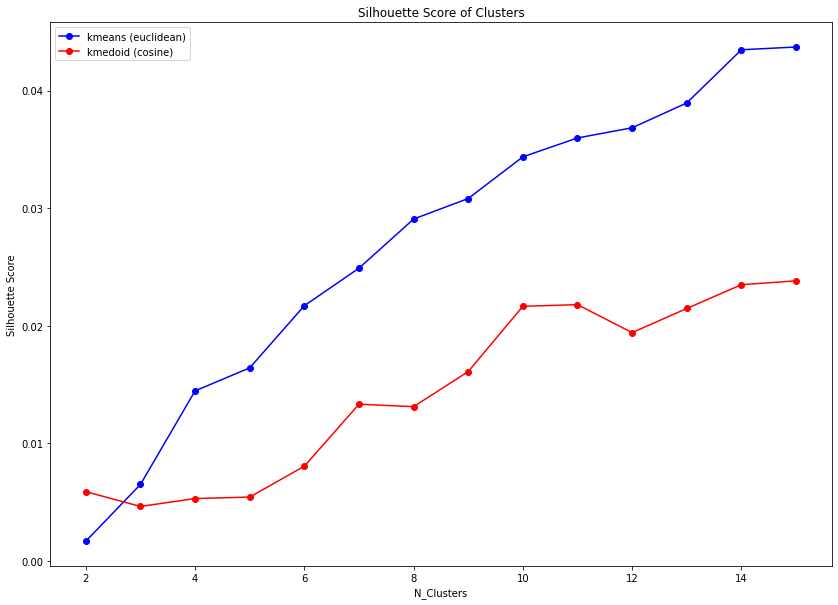

In [22]:
n_clusters = range(2,16)
plt.figure(figsize=(14,10))
plt.plot(n_clusters, k_means_silhouettes_dict.values(), 'bo-', label='kmeans (euclidean)')
plt.plot(n_clusters, k_medoids_silhouettes_dict.values(), 'ro-', label='kmedoid (cosine)')

plt.title('Silhouette Score of Clusters')
plt.ylabel('Silhouette Score')
plt.xlabel('N_Clusters')
plt.legend()
plt.show()

Elbows at n_clusters = 7 (KMedoids), n_clusters = 10 (KMedoids), n_clusters = 4 (KMeans)
<br><br>
I chose 6 KMedoids clusters because n_clusters = 7 was an elbow, but the 7th cluster was so small (<2% of all articles) and words did not make sense (most started with 'f' or 'e' like a dictionary)
<br><br><br><br><br><br><br><br><br>

### Plot PCA scatter plot with clustering labels for colors

In [23]:
color_dict_labels = {'0': 'xkcd:blue', '1': 'xkcd:light green', '2': 'xkcd:orange',
                     '3': 'xkcd:red', '4': 'xkcd:pink', '5': 'xkcd:yellow',
                     '6': 'xkcd:dark green', '7': 'xkcd:cyan', '8': 'xkcd:navy blue',
                     '9': 'xkcd:maroon', '10': 'xkcd:magenta', '11': 'xkcd:violet',
                     '12': 'xkcd:green', '13': 'xkcd:olive',
                    }
color_dict_domains = {'0': 'red', '1': 'cyan', '2':'cyan', '3': 'black', '4':'green'}

color_dict_bias = {'0': 'black', '1': 'purple', '2':'green', '3': 'cyan', '4':'orange', '5': 'red'}

color_dict_classification = {'0': 'yellow', '1':'red'}

domain_map = {'0': 'dubious',
              '1': 'govt',
              '2': 'news',
              '3': 'unknown domain (not included)',
              '4': 'science'
             }

bias_map = {'0': 'conspiracy',
            '1': 'fake_news',
            '2': 'lean_center',
            '3': 'lean_left',
            '4': 'lean_not_known',
            '5': 'lean_right',
            }



Text(0.5, 1.0, 'K_Medoids 6 Clusters')

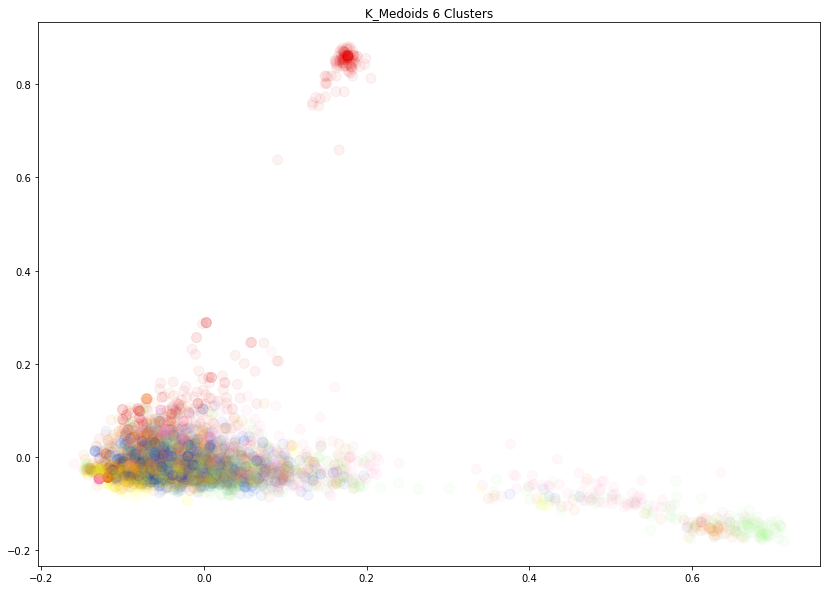

In [91]:
plt.figure(figsize=(14,10))
plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in k_medoids_preds_dict['k_medoids_6']],
                        alpha=.05,
                        s = 100
                       )
plt.title('K_Medoids 6 Clusters')

Text(0.5, 1.0, 'Colored by Anti-Vax Classification\nRed=Anti-Vax')

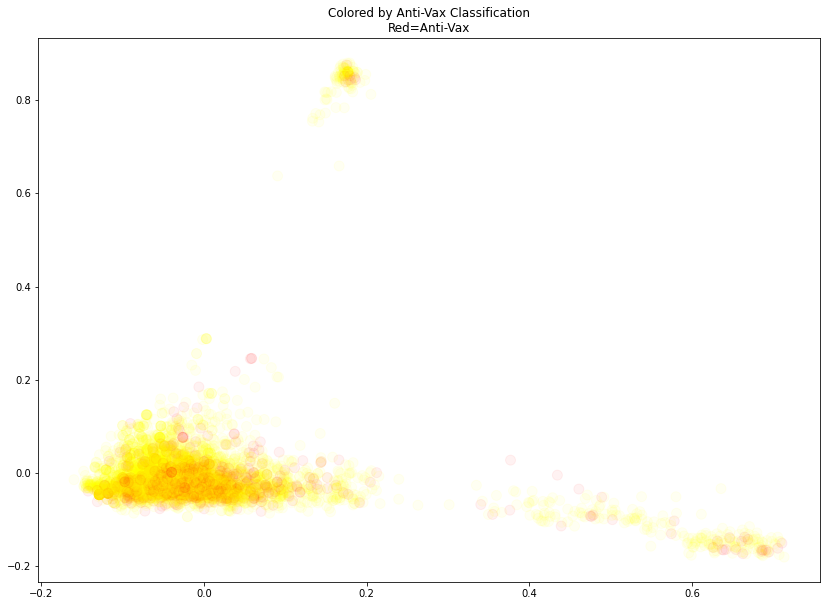

In [50]:
plt.figure(figsize=(14,10))
plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_classification[str(i)] for i in metadata_df['classified']],
                        alpha=.05,
                        s = 100
                       )
plt.title('Colored by Anti-Vax Classification\nRed=Anti-Vax')

# Make the Ready DFs

In [81]:

print(f'pca_df.shape: {pca_df.shape}')
print(f'tfidf_df.shape: {tfidf_df.shape}')
print(f'metadata_df.shape: {metadata_df.shape}')

metadata_cols_to_keep = ['url_total_retweets', 'url_total_favorites', 'group', 'bias', 'month', 'week_num', 'classified']
metadata_small = metadata_df.copy(deep=True)
metadata_small = metadata_small[metadata_cols_to_keep]

print(f'pca_df.shape: {pca_df.shape}')
print(f'tfidf_df.shape: {tfidf_df.shape}')
print(f'metadata_df.shape: {metadata_df.shape}')
print(f'metadata_small.shape: {metadata_small.shape}')


pca_ready = pd.concat([pca_df, metadata_small], axis=1)
tfidf_ready = pd.concat([tfidf_df, metadata_small], axis=1)

print(f'pca_ready.shape: {pca_ready.shape}')
print(f'tfidf_ready.shape: {tfidf_ready.shape}')



pca_ready['k_medoids_6'] = k_medoids_preds_dict['k_medoids_6']
tfidf_ready['k_medoids_6'] = k_medoids_preds_dict['k_medoids_6']

# pca_ready['k_means_4'] = k_means_preds_dict['k_means_4']
# tfidf_ready['k_means_4'] = k_means_preds_dict['k_means_4']

# pca_ready['k_means_6'] = k_means_preds_dict['k_means_6']
# tfidf_ready['k_means_6'] = k_means_preds_dict['k_means_6']

# pca_ready['k_medoids_7'] = k_medoids_preds_dict['k_medoids_7']
# tfidf_ready['k_medoids_7'] = k_medoids_preds_dict['k_medoids_7']

# pca_ready['k_medoids_10'] = k_medoids_preds_dict['k_medoids_10']
# tfidf_ready['k_medoids_10'] = k_medoids_preds_dict['k_medoids_10']




pca_df.shape: (6062, 3)
tfidf_df.shape: (6062, 17764)
metadata_df.shape: (6062, 10)
pca_df.shape: (6062, 3)
tfidf_df.shape: (6062, 17764)
metadata_df.shape: (6062, 10)
metadata_small.shape: (6062, 7)
pca_ready.shape: (6062, 10)
tfidf_ready.shape: (6062, 17771)


In [83]:
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/CLASSIFIED/'
### save ready DFs
with open(load_path + 'tfidf_ready_6062.pkl', 'wb') as f:
    pickle.dump(tfidf_ready, f)

with open(load_path + 'pca_ready_6062.pkl', 'wb') as f:
    pickle.dump(pca_ready, f)




In [3]:
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/CLASSIFIED/'
### load the ready_dfs
with open(load_path + 'tfidf_ready_6062.pkl', 'rb') as f:
    tfidf_ready = pickle.load(f)

with open(load_path + 'pca_ready_6062.pkl', 'rb') as f:
    pca_ready = pickle.load(f)


In [5]:
### load the vectorizer
tfidf_save_name = 'tfidf_vectorizer_of_6062_classified_articles.pkl'
with open(load_path + tfidf_save_name, 'rb') as f:
    vectorizer = pickle.load(f)

<br><br><br><br><br>
# Top Words

In [21]:
def top_words(col_name, label, input_df=tfidf_ready, n_words=200):
   
    df = input_df.copy()
    top_words_list = []
    num_tfidf_features = range(1, tfidf_df.shape[1])    

    temp_df = df[df[col_name] == label]
    
    means = []
    for feat in num_tfidf_features:
#         print(feat)
        means.append(temp_df[feat].mean())
    means = np.array(means)

    feature_array = np.array(vectorizer.get_feature_names())
    sorted_word_idxs = np.argsort(means).flatten()[::-1]
    top_words = list(feature_array[sorted_word_idxs][:n_words])
    return top_words

In [84]:
### make an anti-vax only df, and a non-anti-vax df
anti_vax_tfidf = tfidf_ready[tfidf_ready['classified'] == 1]
neutral_tfidf = tfidf_ready[tfidf_ready['classified'] == 0]

anti_vax_pca = pca_ready[pca_ready['classified'] == 1]
neutral_pca = pca_ready[pca_ready['classified'] == 0]


### Top Words

In [26]:
n_words=500
topics = 6
col_name = 'k_medoids_6'

print(f'\nTop {n_words} words in each of the {topics} clusters from {col_name}')
for i in range(topics):
    print('\n' + '-'*80)
    print(f'\nTopic Group #{i}\n')
    print('All Articles Words')
    print(top_words(col_name = col_name, label=i, n_words=n_words))
    


Top 500 words in each of the 6 clusters from k_medoids_6

--------------------------------------------------------------------------------

Topic Group #0

All Articles Words
['china', 'people', 'cases', 'new', 'world', 'outbreak', 'trials', 'disease', 'researchers', 'research', 'countries', 'scientists', 'global', 'december', 'trial', 'chinese', 'clinical', 'infected', 'testing', 'human', 'university', 'development', 'states', 'united', 'spread', 'wuhan', 'study', 'public', 'reported', 'data', 'confirmed', 'patients', 'infection', 'million', 'according', 'officials', 'science', 'time', 'developed', 'develop', 'deaths', 'national', 'year', 'number', 'trump', 'country', 'test', 'response', 'organization', 'told', 'medical', 'institute', 'president', 'including', 'work', 'government', 'months', 'symptoms', 'tests', 'information', 'director', 'infections', 'tested', 'available', 'epidemic', 'team', 'antibodies', 'immune', 'state', 'phase', 'working', 'potential', 'beijing', 'cdc', 'days'

['people', 'immune', 'trump', 'flu', 'moderna', 'fauci', 'trials', 'antibodies', 'disease', 'doses', 'vaccination', 'like', 'gates', 'cells', 'clinical', 'immunity', 'phase', 'human', 'trial', 'president', 'year', 'safety', 'new', 'cdc', 'study', 'information', 'going', 'dose', 'development', 'research', 'time', 'know', 'nih', 'years', 'children', 'effective', 'drug', 'antibody', 'world', 'company', 'mrna', 'national', 'response', 'public', 'protein', 'infection', 'think', 'work', 'need', 'testing', 'make', 'influenza', 'months', 'vaccinated', 'medical', 'studies', 'million', 'data', 'patients', 'safe', 'facial', 'scientists', 'percent', 'body', 'university', 'infectious', 'developed', 'risk', 'early', 'based', 'potential', 'results', 'way', 'dna', 'available', 'protection', 'candidates', 'using', 'global', 'diseases', 'government', 'right', 'say', 'end', 'cell', 'anti', 'develop', 'science', 'genetic', 'candidate', 'process', 'shot', 'effects', 'companies', 'given', 'used', 'good', 'r

['trump', 'president', 'government', 'new', 'people', 'biden', 'sciencedirect', 'million', 'elsevier', 'world', 'states', 'house', 'billion', 'year', 'state', 'information', 'company', 'doses', 'astrazeneca', 'white', 'public', 'week', 'care', 'country', 'told', 'german', 'mercola', 'provide', 'administration', 'security', 'officials', 'united', 'federal', 'number', 'cases', 'global', 'policy', 'work', 'development', 'time', 'countries', 'deaths', 'crisis', 'york', 'make', 'testing', 'home', 'going', 'manufacturing', 'need', 'end', 'americans', 'according', 'day', 'available', 'read', 'germany', 'lockdown', 'minister', 'secretary', 'department', 'deal', 'licensors', 'like', 'national', 'companies', 'oxford', 'medical', 'research', 'police', 'tailor', 'edt', 'privacy', 'elect', 'added', 'bright', 'today', 'europe', 'working', 'access', 'based', 'university', 'european', 'month', 'social', 'attacks', 'election', 'including', 'donald', 'economy', 'debt', 'leaders', 'trials', 'italy', 'eco

In [108]:
n_words=25
topics = 6
col_name = 'k_medoids_6'

print(f'\nTop {n_words} words in each of the {topics} clusters from {col_name}')
for i in range(topics):
    print('\n' + '-'*80)
    print(f'\nTopic Group #{i}\n')
    print('All Articles Words')
    print(top_words(col_name = col_name, label=i, n_words=n_words))
    print('\n--\nAnti-Vax Words')
    print(top_words(col_name = col_name, label=i, n_words=n_words, input_df = anti_vax_tfidf))
    print('\n--\nNeutral Words')
    print(top_words(col_name = col_name, label=i, n_words=n_words, input_df = neutral_tfidf))
    


Top 25 words in each of the 6 clusters from k_medoids_6

--------------------------------------------------------------------------------

Topic Group #0

All Articles Words
['china', 'people', 'cases', 'new', 'world', 'outbreak', 'trials', 'disease', 'researchers', 'research', 'countries', 'scientists', 'global', 'december', 'trial', 'chinese', 'clinical', 'infected', 'testing', 'human', 'university', 'development', 'states', 'united', 'spread']

--
Anti-Vax Words
['china', 'cases', 'people', 'world', 'disease', 'outbreak', 'new', 'chinese', 'countries', 'infected', 'wuhan', 'study', 'spread', 'deaths', 'reported', 'symptoms', 'trials', 'scientists', 'trial', 'according', 'africa', 'confirmed', 'human', 'december', 'university']

--
Neutral Words
['china', 'people', 'cases', 'new', 'world', 'outbreak', 'trials', 'researchers', 'disease', 'research', 'countries', 'scientists', 'global', 'december', 'clinical', 'trial', 'chinese', 'testing', 'human', 'development', 'university', 'infec

#### Number of Articles Table

In [150]:
print('All Articles, k_medoids_6')
print(tfidf_ready['k_medoids_6'].value_counts().sort_index())

print('\nNOT Anti-Vax, k_medoids_6')
print(neutral_tfidf['k_medoids_6'].value_counts().sort_index())

print('\nAnti-Vax, k_medoids_6')
print(anti_vax_tfidf['k_medoids_6'].value_counts().sort_index())


All Articles, k_medoids_6
0    1652
1    1078
2    1308
3     271
4     937
5     816
Name: k_medoids_6, dtype: int64

NOT Anti-Vax, k_medoids_6
0    1448
1     942
2    1120
3     252
4     819
5     691
Name: k_medoids_6, dtype: int64

Anti-Vax, k_medoids_6
0    204
1    136
2    188
3     19
4    118
5    125
Name: k_medoids_6, dtype: int64


In [148]:

clusters = range(0,6)
topics = ['Coronavirus', 'Response', 'Vaccine Development', 'Finance', 'Politics', 'Conspiracy']
anti_vax_counts = [204, 136, 188, 19, 118, 125]
neutral_counts = [1448, 942, 1120, 252, 819, 691]
total_counts = [1652, 1078, 1308, 271, 937, 816]
percent_anti_vax = [round(100*anti_vax_counts[i]/total_counts[i],2) for i in range(len(total_counts))]
percent_neutral = [round(100*neutral_counts[i]/total_counts[i],2) for i in range(len(total_counts))]


counts_table = PrettyTable()
counts_table.add_column('Cluster #', clusters)
counts_table.add_column('Topic', topics)
counts_table.add_column('Anti-Vax Articles', anti_vax_counts)
counts_table.add_column('Neutral Articles', neutral_counts)
counts_table.add_column('Total Articles', total_counts)
counts_table.add_column('% Anti-Vax', percent_anti_vax)
counts_table.add_column('% Neutral', percent_neutral)

counts_table.title = 'Article Counts'
print(counts_table)


+------------------------------------------------------------------------------------------------------------------+
|                                                  Article Counts                                                  |
+-----------+---------------------+-------------------+------------------+----------------+------------+-----------+
| Cluster # |        Topic        | Anti-Vax Articles | Neutral Articles | Total Articles | % Anti-Vax | % Neutral |
+-----------+---------------------+-------------------+------------------+----------------+------------+-----------+
|     0     |     Coronavirus     |        204        |       1448       |      1652      |   12.35    |   87.65   |
|     1     |       Response      |        136        |       942        |      1078      |   12.62    |   87.38   |
|     2     | Vaccine Development |        188        |       1120       |      1308      |   14.37    |   85.63   |
|     3     |       Finance       |         19        |       25

In [111]:
all_articles_25_words = []
anti_vax_25_words = []
neutral_25_words = []

for i in range(6):
    all_articles_25_words.append(top_words(col_name = 'k_medoids_6', label=i, n_words=25))
    anti_vax_25_words.append(top_words(col_name = 'k_medoids_6', label=i, n_words=25, input_df = anti_vax_tfidf))
    neutral_25_words.append(top_words(col_name = 'k_medoids_6', label=i, n_words=25, input_df = neutral_tfidf))

#### Top Words Table

In [41]:
# all_articles_50_words = []
# for i in range(6):
#     all_articles_50_words.append(top_words(col_name = 'k_medoids_6', label=i, n_words=50))

clusters = [0,1,2,3,4,5]
topics = ['Coronavirus (General)', 'Response/ Lockdowns', 'Scientific Research', 'Finance', 'Politics', 'Conspiracy/Doubts']

words_table = PrettyTable()
words_table.field_names = ['Cluster', 'Topic', 'Top 50 Words']
for i in range(len(clusters)):
    words_table.add_row([clusters[i], topics[i], ', '.join(all_articles_50_words[i]) + '\n'])

words_table._max_width = {'Cluster': 8, 'Topic': 11, 'Top 50 Words': 80}

# k_means_table.align = 'l'

words_table.title = 'Top Words of Each Topic Cluster'
print(words_table)


+----------------------------------------------------------------------------------------------------------+
|                                     Top Words of Each Topic Cluster                                      |
+---------+-------------+----------------------------------------------------------------------------------+
| Cluster |    Topic    |                                   Top 50 Words                                   |
+---------+-------------+----------------------------------------------------------------------------------+
|    0    | Coronavirus |    china, people, cases, new, world, outbreak, trials, disease, researchers,     |
|         |  (General)  |   research, countries, scientists, global, december, trial, chinese, clinical,   |
|         |             |    infected, testing, human, university, development, states, united, spread,    |
|         |             |  wuhan, study, public, reported, data, confirmed, patients, infection, million,  |
|         |        

In [145]:
clusters = [0,1,2,3,4,5]
topics = ['Coronavirus', 'Response', 'Vaccine Development', 'Finance', 'Politics', 'Conspiracy']

words_table = PrettyTable()
words_table.field_names = ['Cluster', 'Topic', 'Top Words (All)', 'Top Words (Anti-Vax)', 'Top Words (Neutral)']
for i in range(len(clusters)):
    words_table.add_row([clusters[i], topics[i], ', '.join(all_articles_25_words[i]) + '\n', ', '.join(anti_vax_25_words[i]) + '\n', ', '.join(neutral_25_words[i]) + '\n'])




# words_table.add_column('Cluster #', clusters)
# words_table.add_column('Topic', topics)
# words_table.add_column('All Articles Words', all_articles_25_words)
# words_table.add_column('Anti-Vax Words', anti_vax_25_words)
# words_table.add_column('Neutral Words', neutral_25_words)


words_table._max_width = {'Cluster': 8, 'Topic': 11, 'Top Words (All)': 25, 'Top Words (Anti-Vax)':25, 'Top Words (Neutral)':25}

# k_means_table.align = 'l'

words_table.title = 'Top Words'
print(words_table)


+-----------------------------------------------------------------------------------------------------------+
|                                                 Top Words                                                 |
+---------+-------------+---------------------------+---------------------------+---------------------------+
| Cluster |    Topic    |      Top Words (All)      |    Top Words (Anti-Vax)   |    Top Words (Neutral)    |
+---------+-------------+---------------------------+---------------------------+---------------------------+
|    0    | Coronavirus |   china, people, cases,   |   china, cases, people,   |   china, people, cases,   |
|         |             |   new, world, outbreak,   | world, disease, outbreak, |   new, world, outbreak,   |
|         |             |      trials, disease,     |  new, chinese, countries, |    trials, researchers,   |
|         |             |   researchers, research,  |  infected, wuhan, study,  |     disease, research,    |
|         

<br><br><br><br><br><br>
# Plotting

In [6]:
def plot_clusters(title: str, unit = "-1", col = 'k_medoids_6', color_by = 'k_medoids_6', input_df=pca_ready, label1=-1, label2=-1, label3 = -1, label4=-1, label_exclude=-1, alpha=0.05):
    df = input_df.copy()
    print('col: ' + col )
    print('time unit: ' + unit)
    print('color_by: ' + color_by)
    
    ### color by
    if color_by == 'k_medoids_6':
        color_dict = color_dict_labels
        print('Coloring by Topic Labels')
    elif color_by == 'group':
        color_dict = color_dict_domains
        print('Coloring by Domain Group')
    elif color_by == 'bias':
        color_dict = color_dict_bias
        print('Coloring by Political Bias')

    ### exclude
    if label_exclude !=-1:
        df = df[df[col] != label_exclude]
    ### select up to 4 labels (or all labels)
    if (label1 != -1) and (label2 != -1) and (label3 != -1) and (label4 != -1):
        df = df[(df[col] == label1) | (df[col] == label2) | (df[col] == label3) | (df[col] == label4)]    
    elif (label1 != -1) and (label2 != -1) and (label3 != -1):
        df = df[(df[col] == label1) | (df[col] == label2) | (df[col] == label3)]
    elif (label1 != -1) and (label2 != -1):
        df = df[(df[col] == label1) | (df[col] == label2)]
    elif label1 != -1:
        df = df[df[col] == label1]
        
    
    ### time
    if unit != '-1':
        if unit == 'month':
            time = pca_ready['month'].value_counts().sort_index().index
        elif unit == 'week_num':
            time = pca_ready['week_num'].value_counts().sort_index().index


        for t in time:
            plt.figure()
            plt.figure(figsize=(10,8))
            plt.xlim(-.3, .8)
            plt.ylim(-.3, .95)

            df_time = df[df[unit] == t]
    #         print(df_month.shape)

            plt.title(title + '\n' + unit + ': ' + str(t))
            plt.scatter(df_time[1], df_time[2], 
                    c = [color_dict[str(i)] for i in df_time[color_by]],
                    alpha=alpha,
                    s = 100
                   )
    elif unit == '-1':
        plt.figure(figsize=(14,10))
        plt.title(title)
        plt.scatter(df[1], df[2], 
                    c = [color_dict[str(i)] for i in df[color_by]],
                    alpha=alpha,
                    s = 100
                   )
  
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.xlim(-.3,.8)
    plt.ylim(-.3,.95)
    plt.show()

col: k_medoids_6
time unit: -1
color_by: k_medoids_6
Coloring by Topic Labels


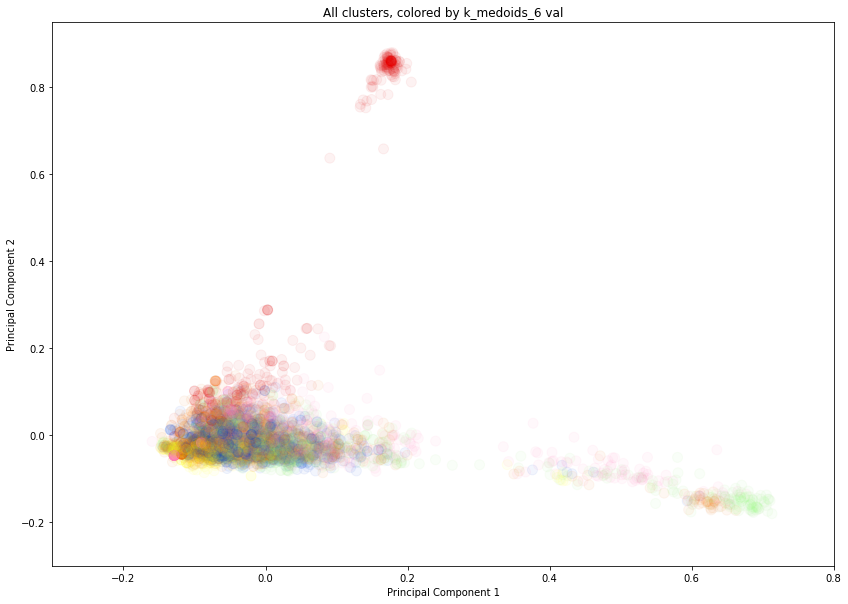

In [154]:
plot_clusters(title='All clusters, colored by k_medoids_6 val')

Each Topic Group
col: k_medoids_6
time unit: -1
color_by: k_medoids_6
Coloring by Topic Labels


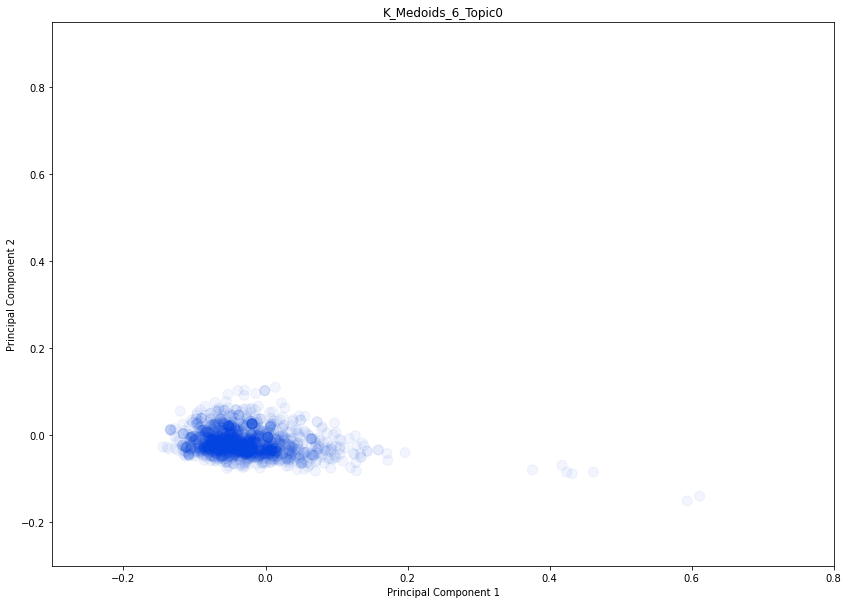

col: k_medoids_6
time unit: -1
color_by: k_medoids_6
Coloring by Topic Labels


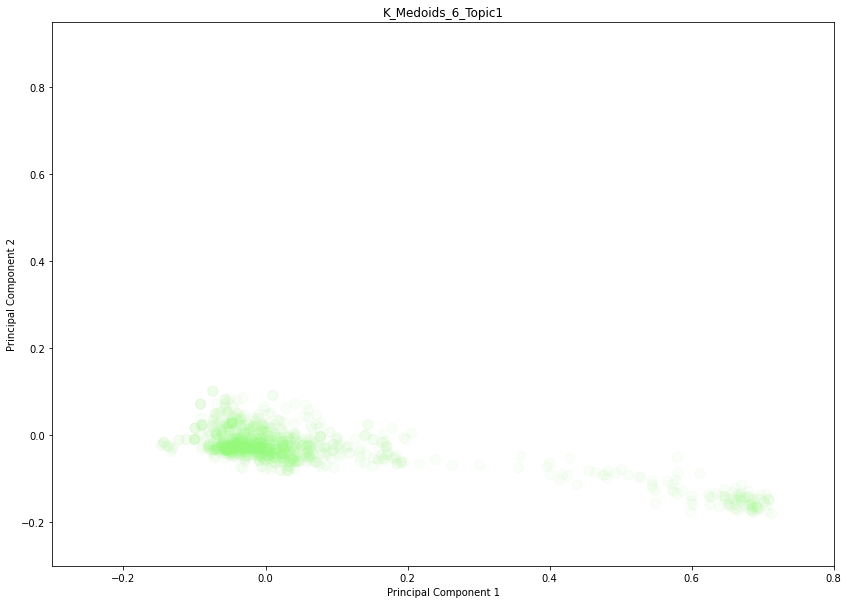

col: k_medoids_6
time unit: -1
color_by: k_medoids_6
Coloring by Topic Labels


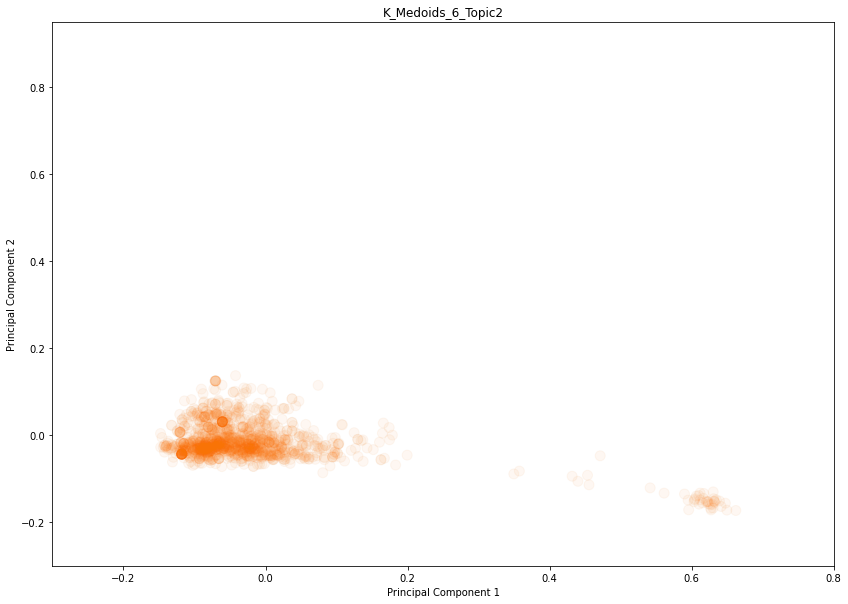

col: k_medoids_6
time unit: -1
color_by: k_medoids_6
Coloring by Topic Labels


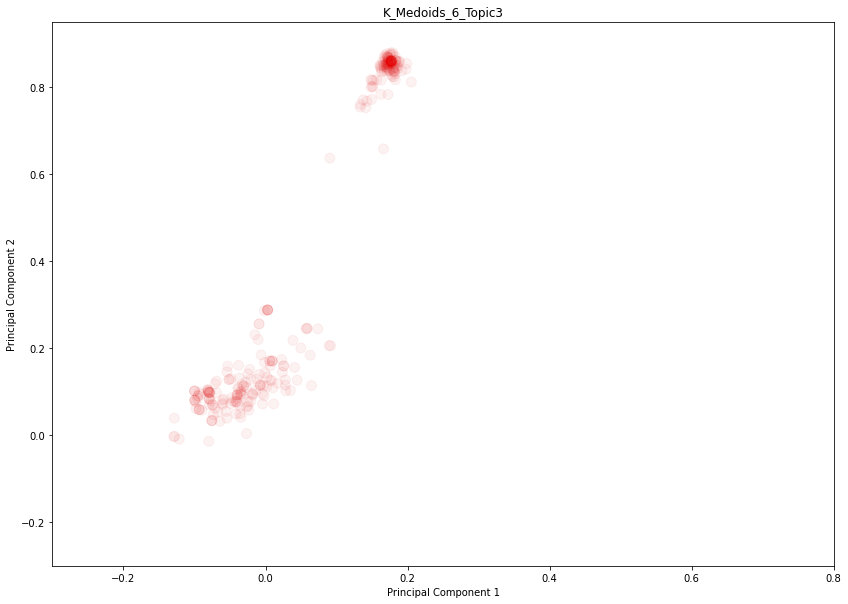

col: k_medoids_6
time unit: -1
color_by: k_medoids_6
Coloring by Topic Labels


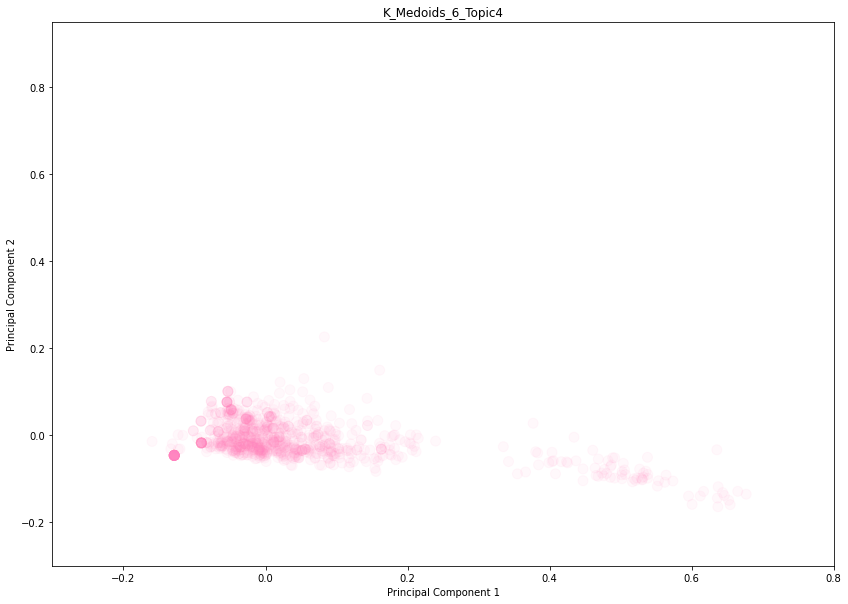

col: k_medoids_6
time unit: -1
color_by: k_medoids_6
Coloring by Topic Labels


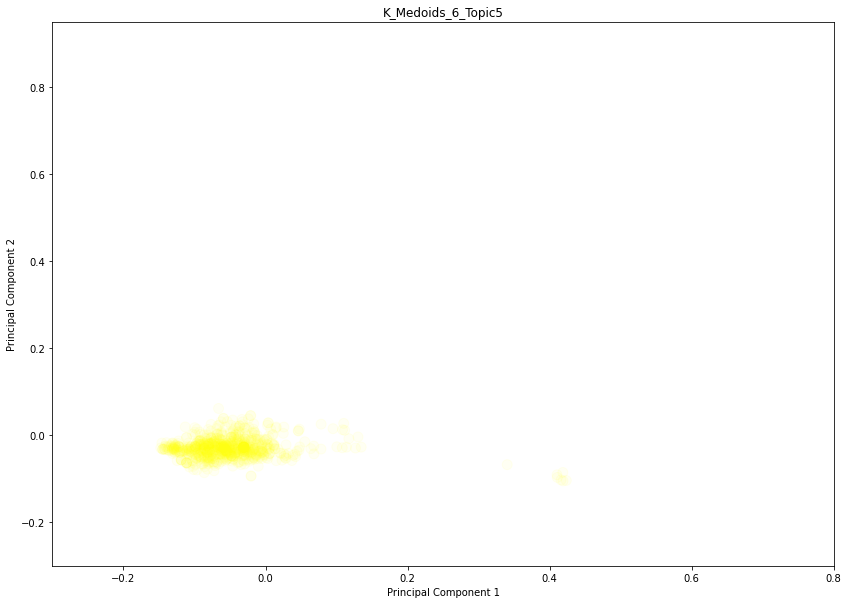

In [156]:
### Many topics overlap in 2-d plot
print('Each Topic Group')
for i in range(6):
    plot_clusters(title='K_Medoids_6_Topic' + str(i), label1=i)

<br><br><br><br><br>
# Heatmaps

In [31]:
weeks = pca_ready['week_num'].value_counts().sort_index().index
def article_counts_matrix(time_name:str, normalize_on:str, input_df = pca_ready, col='k_medoids_6'):
    df = input_df.copy(deep=True)
    months = df['month'].value_counts().sort_index().index
    weeks = df['week_num'].value_counts().sort_index().index
    if time_name == 'month':
        times = months
    elif time_name == 'week_num':
        times = weeks


    all_topics = []
    for topic in sorted(input_df[col].unique()):
        this_topic = []
    #     print(f'\ntopic: {topic}')
        topic_sum = df[df[col] == topic].shape[0]
    #     print(f'topic sum: {topic_sum}')
        for time_unit in times:
            this_topic.append(df[(df[col] == topic) & (df[time_name] == time_unit)].shape[0])
    #     print(this_topic)
        all_topics.append(this_topic)
    #     print(f'all topics: {all_topics}')

    raw_counts = np.vstack(np.asarray(topic_list) for topic_list in all_topics)
    normalized = raw_counts.astype('float32')
    
    if normalize_on == 'topic':
#         for i in range(normalized.shape[0]):
#             temp = normalized[i].copy()
#             row_sum = float(temp.sum())
#             temp = temp/row_sum
#             normalized[i] = temp
        return normalized/normalized.sum(axis=1,keepdims=1)
    elif normalize_on == 'time':
        return normalized/normalized.sum(axis=0,keepdims=1)



<br><br><br><br>
## Normalized by Topic (horizontally)

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

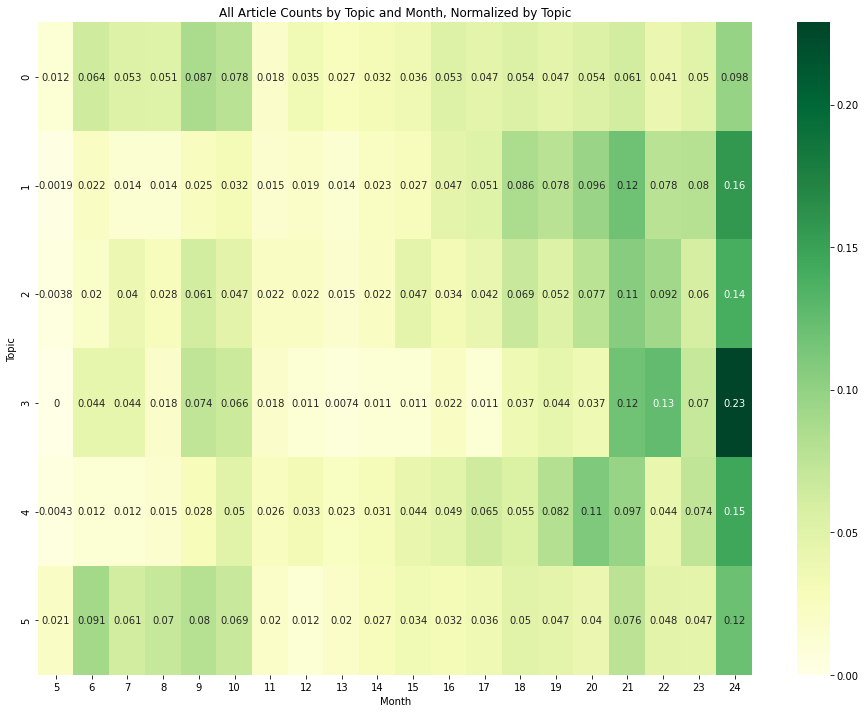

In [200]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_month_topic_normalized = article_counts_matrix(time_name='week_num', normalize_on='topic')
sns.heatmap(counts_by_month_topic_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('All Article Counts by Topic and Month, Normalized by Topic')
ax.set_xlabel('Month')
ax.set_ylabel('Topic')


- Topic 0 (coronavirus) and Topic 5 (conspiracy) start strong, decrease until June
- Topics 1 (response), 2 (vaccine development), 3 (finance), 4 (politics) start slow, grow over time (May > Feb)

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

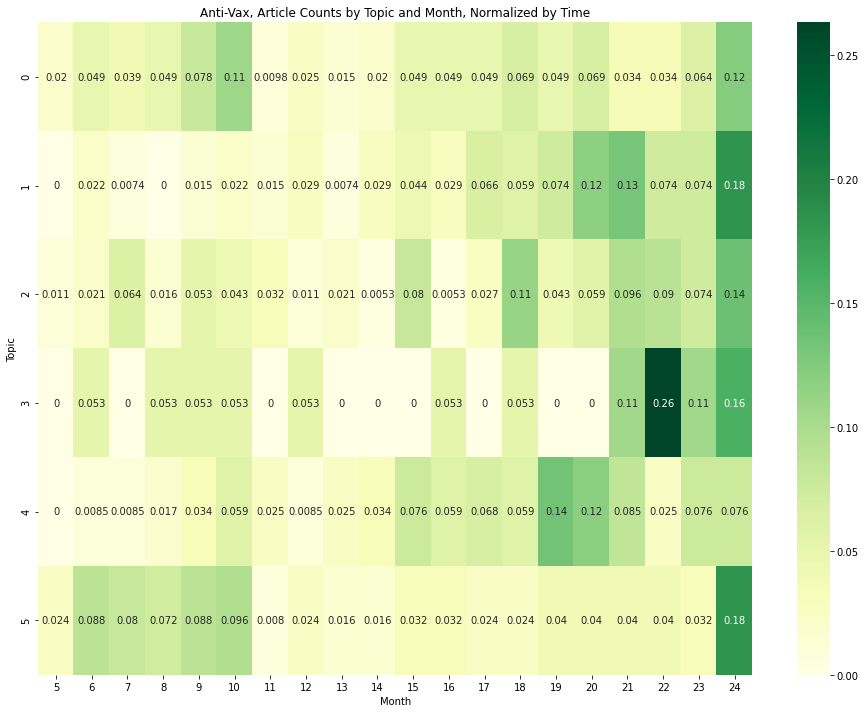

In [202]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_month_time_normalized = article_counts_matrix(input_df = anti_vax_pca, time_name='week_num', normalize_on='topic')
sns.heatmap(counts_by_month_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Anti-Vax, Article Counts by Topic and Month, Normalized by Time')
ax.set_xlabel('Month')
ax.set_ylabel('Topic')

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

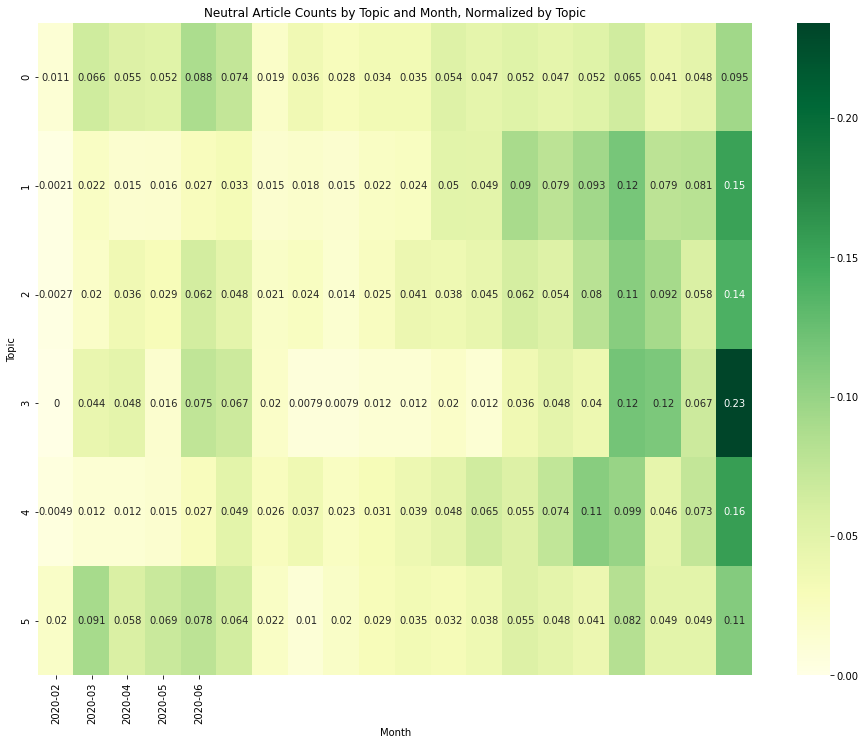

In [203]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_month_time_normalized = article_counts_matrix(input_df = neutral_pca, time_name='week_num', normalize_on='topic')
sns.heatmap(counts_by_month_time_normalized, annot=True, cmap='YlGn', xticklabels=months, ax=ax)
ax.set_title('Neutral Article Counts by Topic and Month, Normalized by Topic')
ax.set_xlabel('Month')
ax.set_ylabel('Topic')


- Match up of neutral + anti_vax articles mean both groups generally talking about the same thing. There's a focus on winning the same narratives

<br><br><br><br>
## Normalized by Time (vertically)

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

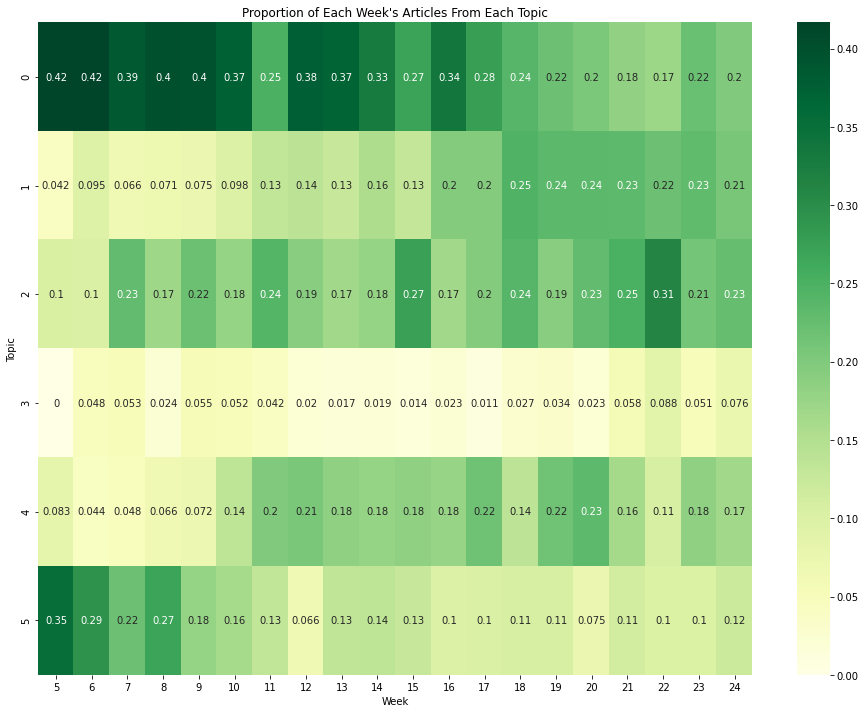

In [33]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(time_name='week_num', normalize_on='time')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Proportion of Each Week\'s Articles From Each Topic')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- Topic 0 - Coronavirus - is dominant in early weeks then ebbs a bit, but strong throughout
- Topic 1 - Response - is nonexistant early, then grows by May/June
- Topic 2 - Vaccine Development - Has a few strong weeks early (wishful thinking?) but really gets strong late (late May/June)
- Topic 3 - Finance - Never strong
- Topic 4 - Politics - Grows in the middle (march/april) likely during lockdowns / stimulus checks stays relevant to end
- Topic 5 - conspiracy - very strong early, clearly competing for airtime/narrative dominance

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

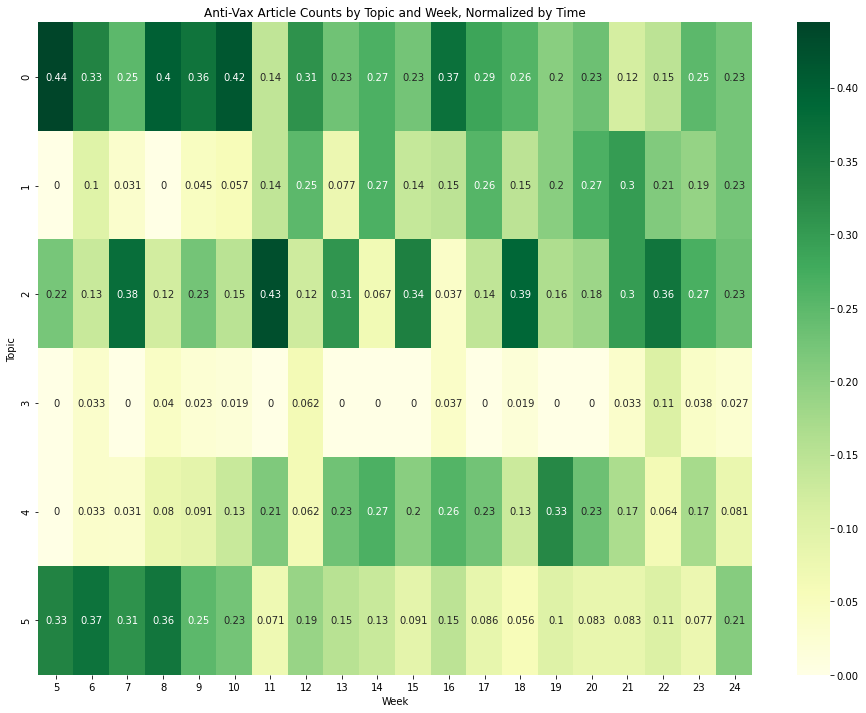

In [177]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = anti_vax_pca, time_name='week_num', normalize_on='time')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Anti-Vax Article Counts by Topic and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- Anti-vax articles shift to a focus on vaccines/vaccine development, politics, and response before neutral articles. Shift appears quicker (dark --> yellow) (jumping back and forth between narratives) rather than gradual ramp up or slow down in the case of neutral articles

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

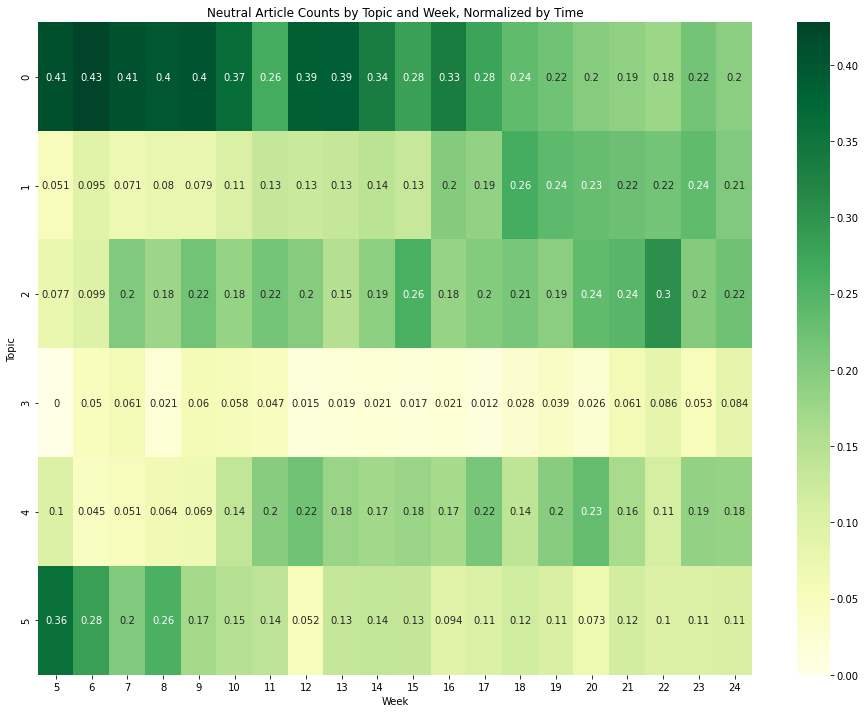

In [178]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = neutral_pca, time_name='week_num', normalize_on='time')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Neutral Article Counts by Topic and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

<br><br><br><br>
## Domain groups

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

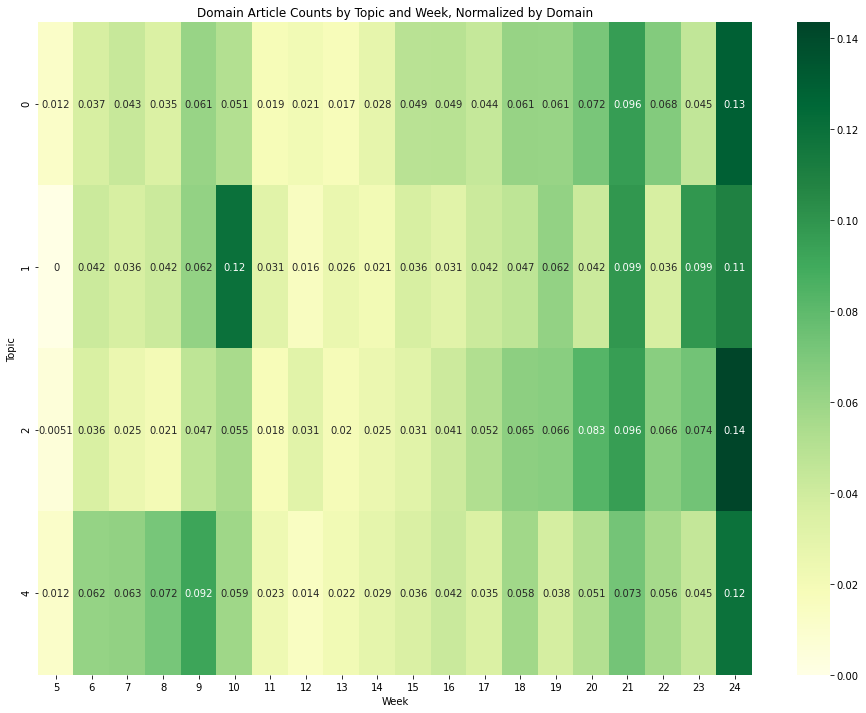

In [206]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(time_name='week_num', normalize_on='topic', col='group')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,4], ax=ax)
ax.set_title('Domain Article Counts by Topic and Week, Normalized by Domain')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- All domains except science slow to start

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Dubious'),
  Text(0, 1.5, 'Government'),
  Text(0, 2.5, 'News'),
  Text(0, 3.5, 'Science')])

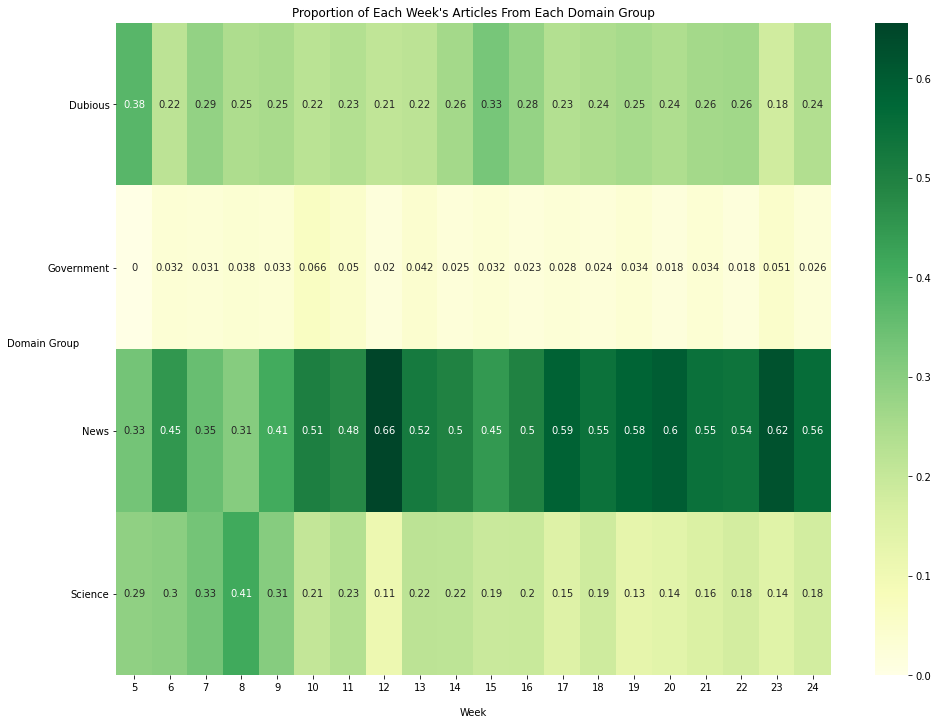

In [57]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(time_name='week_num', normalize_on='time', col='group')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = domain_group_labels, ax=ax)
ax.set_title('Proportion of Each Week\'s Articles From Each Domain Group')
ax.set_xlabel('\nWeek')
ax.set_ylabel('Domain Group', rotation = 0)
plt.yticks(rotation=0)
# plt.ylabel(rotation=90)

- Topic 0 (dubious domains) is the largest at the beginning ... quick start. Stays around (25% of articles)
- Topic 1 (government) by far the weakest throughout (lack of government messaging?)
- Topic 2 (news) strong and gets stronger
- Topic 4 (science) strong to start, then becomes less prevalent than dubious

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

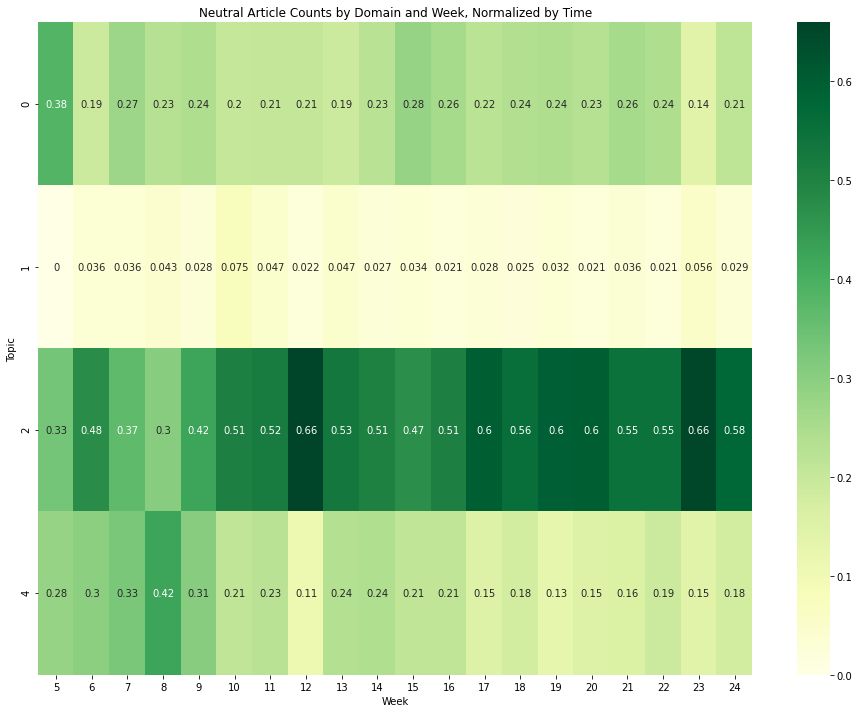

In [216]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = neutral_pca, time_name='week_num', normalize_on='time', col='group')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,4], ax=ax)
ax.set_title('Neutral Article Counts by Domain and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- Neutral articles 
    - heavy on science early, then slows
    - heavy on news throughout
    - dubious up front, moderate through the rest

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

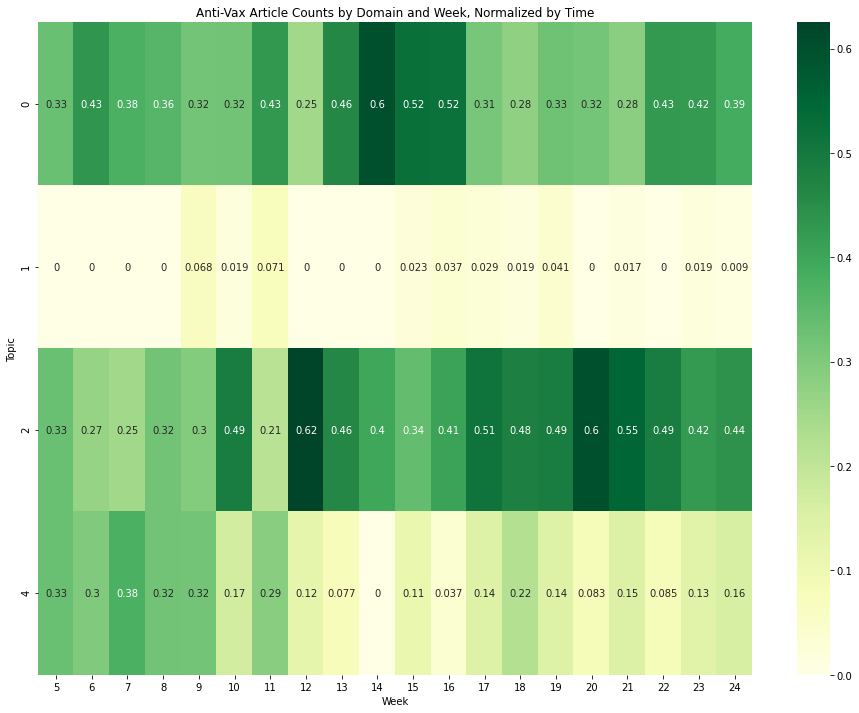

In [217]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = anti_vax_pca, time_name='week_num', normalize_on='time', col='group')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,4], ax=ax)
ax.set_title('Anti-Vax Article Counts by Domain and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- Anti-Vax Articles
    - Heavy on dubious domains throughout (confirms that dubious domains are dubious!)
    - Lots of news, just like neutral articles
    - Similar use of science early. What is the sentiment?

<br><br><br><br>
## Bias

bias_map = {'0': 'conspiracy',
            '1': 'fake_news',
            '2': 'lean_center',
            '3': 'lean_left',
            '4': 'lean_not_known',
            '5': 'lean_right',
            }

In [231]:
bias_known = pca_ready[pca_ready['bias'] != 4]
print('Known bias neutral and anti-vax articles')
print(bias_known['classified'].value_counts())
print('\nBias known... bias value counts')
print(bias_known['bias'].value_counts())

bias_known_anti_vax = pca_ready[(pca_ready['bias'] != 4) & (pca_ready['classified'] == 1)]
bias_known_neutral = pca_ready[(pca_ready['bias'] != 4) & (pca_ready['classified'] == 0)]

Known bias neutral and anti-vax articles
0    2731
1     500
Name: classified, dtype: int64

Bias known... bias value counts
3    1330
1     613
2     464
0     448
5     376
Name: bias, dtype: int64


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

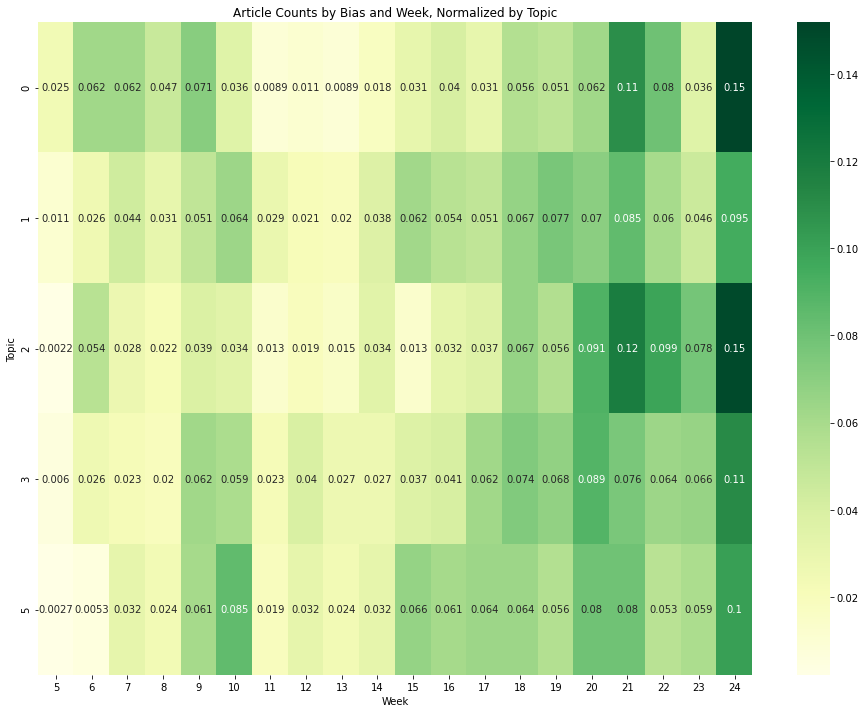

In [237]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = bias_known, time_name='week_num', normalize_on='topic', col='bias')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,3,5], ax=ax)
ax.set_title('Article Counts by Bias and Week, Normalized by Topic')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- all topics grow over time, but conspiracy, center-lean in particular

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

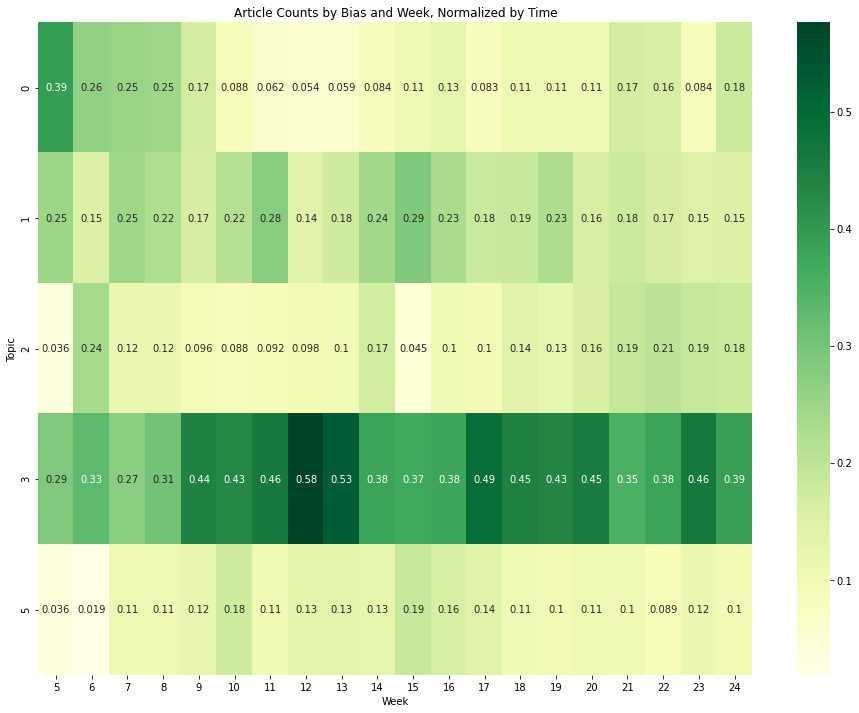

In [232]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = bias_known, time_name='week_num', normalize_on='time', col='bias')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,3,5], ax=ax)
ax.set_title('Article Counts by Bias and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- For all known-bias articles, Mostly lean left (mostly news?)
- First week: 0.39 articles with known bias were conspiracy, 0.25 were fake-news
    - Fast start for conspiracy and fake-news versus center, left, and right-leaning

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

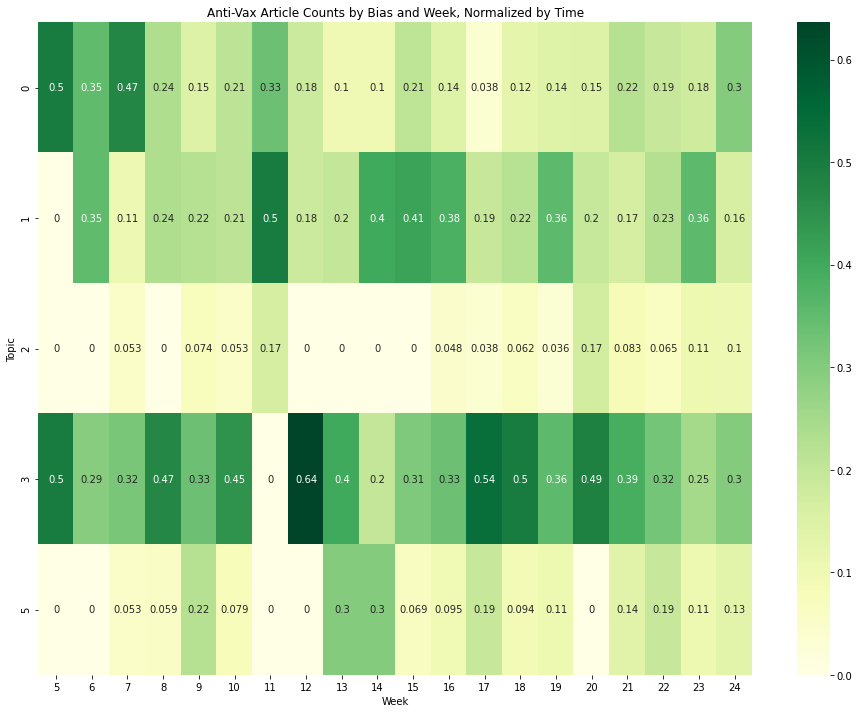

In [233]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = bias_known_anti_vax, time_name='week_num', normalize_on='time', col='bias')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,3,5], ax=ax)
ax.set_title('Anti-Vax Article Counts by Bias and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

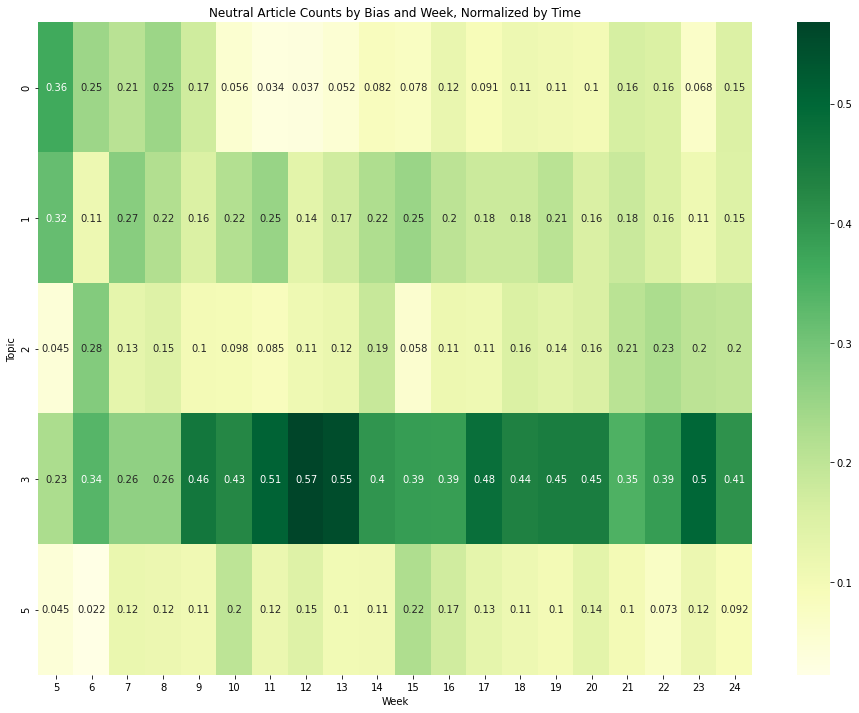

In [234]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = bias_known_neutral, time_name='week_num', normalize_on='time', col='bias')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,3,5], ax=ax)
ax.set_title('Neutral Article Counts by Bias and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

- Anti-Vax utilizes conspiracy and fake-news articles more than neutral tweets
- Anti-vax utilizes right-leaning political domains more than neutral tweets

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

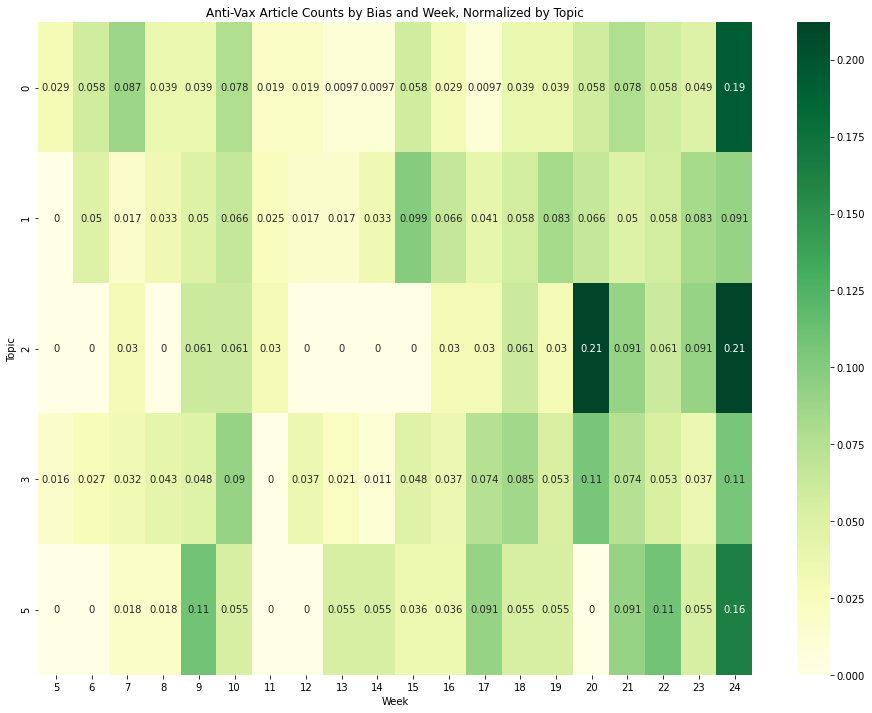

In [235]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(input_df = bias_known_anti_vax, time_name='week_num', normalize_on='topic', col='bias')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, yticklabels = [0,1,2,3,5], ax=ax)
ax.set_title('Anti-Vax Article Counts by Bias and Week, Normalized by Topic')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

# ================================================
<br><br><br><br><br><br>

# Topics vs Domains


In [11]:
def domains_vs_topics(normalize_on:str, input_df = pca_ready, col='k_medoids_6'):
    df = input_df.copy(deep=True)
#     months = df['month'].value_counts().sort_index().index
#     weeks = df['week_num'].value_counts().sort_index().index
#     if time_name == 'month':
#         times = months
#     elif time_name == 'week_num':
#         times = weeks


    all_topics = []
    for topic in sorted(input_df[col].unique()):
        this_topic = []
    #     print(f'\ntopic: {topic}')
#         topic_sum = df[df[col] == topic].shape[0]
#     #     print(f'topic sum: {topic_sum}')
        for group in sorted(df['group'].unique()):
            this_topic.append(df[(df[col] == topic) & (df['group'] == group)].shape[0])
        all_topics.append(this_topic)
    #     print(f'all topics: {all_topics}')

    raw_counts = np.vstack(np.asarray(topic_list) for topic_list in all_topics)
    normalized = raw_counts.astype('float32')
    
    if normalize_on == 'topic':
#         for i in range(normalized.shape[0]):
#             temp = normalized[i].copy()
#             row_sum = float(temp.sum())
#             temp = temp/row_sum
#             normalized[i] = temp
        return normalized/normalized.sum(axis=1,keepdims=1)
    elif normalize_on == 'group':
        return normalized/normalized.sum(axis=0,keepdims=1)


In [15]:
print(domains_vs_topics(normalize_on='group'))
print()
print(domains_vs_topics(normalize_on='topic'))

[[0.27807486 0.29166666 0.25552747 0.3071192 ]
 [0.14639038 0.140625   0.22773215 0.09188741]
 [0.23462567 0.1875     0.16582438 0.32781458]
 [0.01136364 0.015625   0.07738471 0.00496689]
 [0.12299465 0.28125    0.19772583 0.06043046]
 [0.2065508  0.08333334 0.07580543 0.20778146]]

[[0.25181597 0.03389831 0.48970944 0.22457626]
 [0.20315398 0.02504638 0.66883117 0.10296846]
 [0.26834863 0.02752294 0.40137616 0.3027523 ]
 [0.06273063 0.01107011 0.90405905 0.02214022]
 [0.19637139 0.05763074 0.6680896  0.07790822]
 [0.37867647 0.01960784 0.29411766 0.30759802]]


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

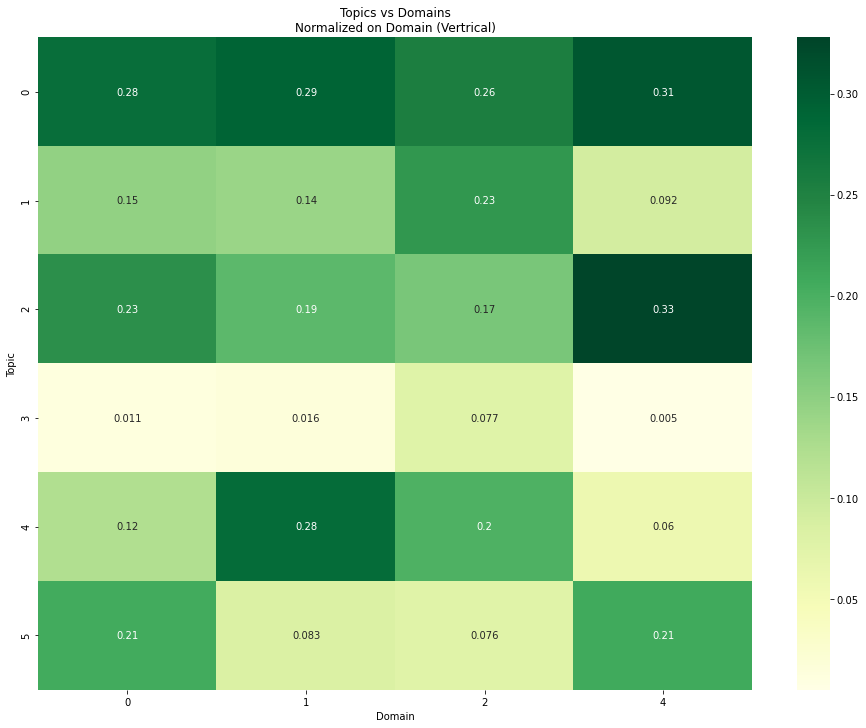

In [20]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
topic_x_domain_normalized = domains_vs_topics(normalize_on='group')
sns.heatmap(topic_x_domain_normalized, annot=True, cmap='YlGn', xticklabels=[0,1,2,4], yticklabels = range(6), ax=ax)
ax.set_title('Topics vs Domains\nNormalized on Domain (Vertrical)')
ax.set_xlabel('Domain')
ax.set_ylabel('Topic')

/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

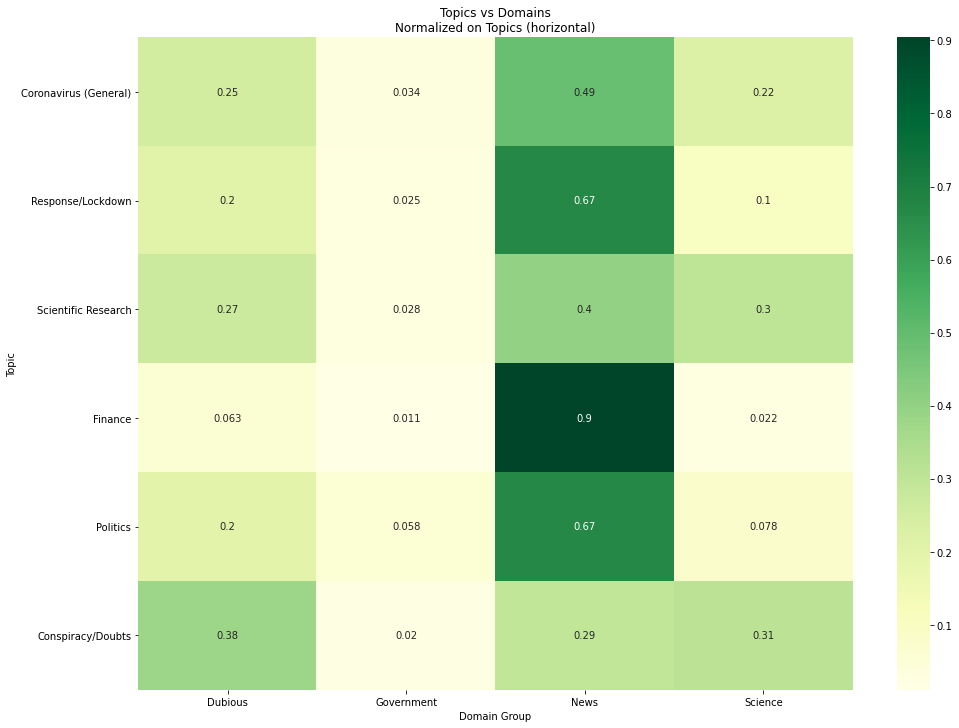

In [47]:
domain_group_labels = ['Dubious', 'Government', 'News', 'Science']
topic_group_labels = ['Coronavirus (General)', 'Response/Lockdown', 'Scientific Research', 'Finance', 'Politics', 'Conspiracy/Doubts']


plt.figure(figsize=(16, 12))
ax = plt.axes()
topic_x_domain_normalized = domains_vs_topics(normalize_on='topic')
sns.heatmap(topic_x_domain_normalized, annot=True, cmap='YlGn', xticklabels=domain_group_labels, yticklabels = topic_group_labels, ax=ax)
ax.set_title('Topics vs Domains\nNormalized on Topics (horizontal)')
ax.set_xlabel('Domain Group')
ax.set_ylabel('Topic')

- dubious domains (0) accounted for 2nd highest source of topics 0 (coronavirus general), 1 (response/lockdowns), 3 (finance) (though minimal), 4 (politics), and top source of (5) conspiracy/origin
- government domain (1) was by far the lowest content producer for each topic
- News (2) was highest for all categories except 5, conspiracy/origins
- Science (4) was 2nd highest for vaccine development (behind news), 2nd highest for origins (behind dubious), low for politics, low for response/lockdown. 

# --------------------------------------------------------------------------

### chi-square

In [4]:
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/CLASSIFIED/'
with open(load_path + 'metadata_plus_classification_6063.pkl', 'rb') as f:
    metadata_df = pickle.load(f)

load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/CLASSIFIED/'
### load the ready_dfs
with open(load_path + 'tfidf_ready_6062.pkl', 'rb') as f:
    tfidf_ready = pickle.load(f)

with open(load_path + 'pca_ready_6062.pkl', 'rb') as f:
    pca_ready = pickle.load(f)

In [5]:
pca_ready.head()

,id_str,1,2,url_total_retweets,url_total_favorites,group,bias,month,week_num,classified,k_medoids_6
0,1233899679924006912,-0.089848,0.011854,1724,1166,0,5,2020-02,9,0,0
1,1233899753815134208,-0.065137,-0.007283,73061,2115,2,3,2020-02,9,0,5
2,1233900236768186368,0.064970,-0.008060,0,0,2,2,2020-02,9,0,0
3,1233903932503711744,-0.018664,-0.024155,48,71,2,3,2020-02,9,0,0
4,1233901044175982592,-0.079942,-0.065282,21,18,4,4,2020-02,9,0,5


In [7]:
import scipy.stats as scs

def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)

temp = pca_ready[['group', 'k_medoids_6']]
temp = temp +1
temp.head()

# test_df = pd.read_csv('test_data_for_chi_square.csv')
print(chi_square_of_df_cols(temp, 'group', 'k_medoids_6'))

In [18]:
from scipy.stats import chi2_contingency

temp = pca_ready[['group', 'k_medoids_6', 'bias']]

def chi_2(df, col1, col2):
    # Contingency table.
    contingency = pd.crosstab(df[col1], df[col2])

    # Chi-square test of independence
    c, p, dof, expected = chi2_contingency(contingency)
    print('chi-square test for {col1} and {col2}:')
    print(f'c: {c}')
    print(f'p: {p}')
    print(f'dof: {dof}')
    print(f'expected: \n{np.matrix(expected)}')

In [21]:
pd.crosstab(temp['group'], temp['k_medoids_6'])

k_medoids_6,0,1,2,3,4,5
group,,,,,,
0,416,219,351,17,184,309
1,56,27,36,3,54,16
2,809,721,525,245,626,240
4,371,111,396,6,73,251


In [20]:
chi_2(temp, 'group', 'k_medoids_6')
### p-val < 0.05, there is a relationship

chi-square test for {col1} and {col2}:
c: 710.2471272615501
p: 1.2165485780104493e-141
dof: 15
expected: 
[[407.68591224 266.03233256 322.79247773  66.878258   231.23589574
  201.37512372]
 [ 52.32332564  34.14318707  41.42791158   8.58330584  29.67733421
   25.84493566]
 [862.78983834 563.00692841 683.12900033 141.53513692 489.36687562
  426.17222039]
 [329.20092379 214.81755196 260.65061036  54.00329924 186.71989442
  162.60772022]]


In [17]:
chi_2(temp, 'bias', 'k_medoids_6')
### p-val < 0.05, there is a relationship

chi-square test for {col1} and {col2}:
c: 707.4831405271289
p: 3.6304910236092386e-133
dof: 25
expected: 
[[122.08775982  79.66743649  96.66512702  20.02771363  69.24711316
   60.30484988]
 [167.05311778 109.00923788 132.26723854  27.40399208  94.75107225
   82.51534147]
 [126.44803695  82.51270208 100.11745299  20.74298911  71.72022435
   62.45859452]
 [362.44803695 236.51270208 286.97459584  59.45727483 205.57736721
  179.03002309]
 [771.4965358  503.43418014 610.84592544 126.55905642 437.58611019
  381.07819202]
 [102.4665127   66.86374134  81.12966018  16.80897394  58.11811283
   50.61299901]]


# ------------------------------------------------------------------------
# Nothing below here
<br><br><br><br><br><br><br>
# Average Linkage Between Domains and Topics

In [ ]:
### too hard to see bias/domain in topics using 2-d plot
# for i in range(8):
#     plot_clusters(title='topic coloring topic {}'.format(i), color_by = 'k_medoids_8', label1=i)
#     plot_clusters(title='bias coloring topic {}'.format(i), color_by = 'bias', label1=i)
#     plot_clusters(title='domain coloring topic {}'.format(i), color_by = 'group', label1=i)

In [ ]:
# def select_points_tfidf(col, label):
#     temp = tfidf_ready[tfidf_ready[col] == label]
#     temp = temp.iloc[:, 1:20213]
#     return temp.to_numpy()

# def select_points_pca(col, label):
#     temp = pca_ready[pca_ready[col] == label]
#     temp = temp.iloc[:, 1:3]
#     return temp.to_numpy()

# def average_distance(matrix1, matrix2, metric='euclidean'):    
#     n1 = matrix1.shape[0]
#     n2 = matrix2.shape[0]

#     sum_dists = 0
    
#     for i in range(n1):
#         for j in range(n2):
#             if metric=='cosine': # better for high dimensions
#                 sum_dists += cosine(matrix1[i], matrix2[j])
#             elif metric == 'euclidean':
#                 sum_dists += euclidean(matrix1[i], matrix2[j])
#     avg_dists = sum_dists/(n1*n2)
#     return avg_dists

# def compute_average_linkage(col1, label1, col2, label2, title:str, points='pca', metric='euclidean'):
#     if points == 'pca':
#         points1 =  select_points_pca(col1, label1)
#         points2 = select_points_pca(col2, label2)
#     ### doing it with TFIDF features would take 45+ minutes per comparison
#     elif points == 'tfidf':
#         points1 = select_points_tfidf(col1, label1)
#         points2 = select_points_tfidf(col2, label2)
#     avg_dist = average_distance(points1, points2, metric=metric)
#     print(title + ': ' + str(avg_dist))
#     return avg_dist


# ### doing with TFIDF features would be 45+ min per combo
# # dubious_points_tfidf = select_points_tfidf('group', 0)
# # science_points_tfidf = select_points_tfidf('group', 4)

# # n1 = dubious_points_tfidf.shape[0]
# # n2 = science_points_tfidf.shape[0]

# # sum_dists = 0
# # for i in tqdm(range(n1)):
# #     for j in range(n2):
# #         sum_dists += cosine(dubious_points_tfidf[i], science_points_tfidf[j])
# # avg_dists = sum_dists/(n1*n2)
# # print(avg_dists)

In [ ]:
# print('Average Linkage')
# print('----- Dubious vs Topic Groups ----')
# for i in range(8):
#     compute_average_linkage('group', 0, 'k_medoids_8', i, title='Dubious vs Topic Group {}'.format(i))

In [ ]:
# print('----- Domain vs Topic Groups ----')
# dubious_vs_topic = {}
# govt_vs_topic = {}
# news_vs_topic = {}
# science_vs_topic = {}

# for i in tqdm(range(8)):
#     dubious_vs_topic[str(i)] = (compute_average_linkage('group', 0, 'k_medoids_8', i, title='Dubious vs Topic {}'.format(i)))
#     govt_vs_topic[str(i)] = (compute_average_linkage('group', 1, 'k_medoids_8', i, title='Govt vs Topic {}'.format(i)))
#     news_vs_topic[str(i)] = (compute_average_linkage('group', 2, 'k_medoids_8', i, title='News vs Topic {}'.format(i)))
#     science_vs_topic[str(i)] = (compute_average_linkage('group', 4, 'k_medoids_8', i, title='Science vs Topic {}'.format(i)))

# zero = np.asarray(list(dubious_vs_topic.values()))
# one = np.asarray(list(govt_vs_topic.values()))
# two = np.asarray(list(news_vs_topic.values()))
# four = np.asarray(list(science_vs_topic.values()))

# domain_vs_topic = np.vstack((zero, one, two, four))
# print(type(domain_vs_topic))

# plt.figure(figsize=(16, 12))
# ax = plt.axes()
# sns.heatmap(domain_vs_topic, annot=True, cmap='OrRd', xticklabels=range(0,8), yticklabels=[0,1,2,4], ax=ax)
# ax.set_title('Distance between Domain and Topic')
# ax.set_xlabel('Topic')
# ax.set_ylabel('Domain')